In [1]:
import os
import pickle
import numpy as np
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dropout, Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

In [3]:
from tensorflow.keras.layers import LSTM, Dropout

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


merged_data = pd.read_csv(r"3_labels.csv")


In [5]:
merged_data.head()

,chest_ax,chest_ay,chest_az,chest_ecg,chest_emg,chest_eda,chest_temp,chest_resp,label
0,0.9554,-0.2220,-0.5580,0.021423,-0.004440,5.250549,30.120758,-1.148987,0.0
1,0.9258,-0.2216,-0.5538,0.020325,0.004349,5.267334,30.129517,-1.124573,0.0
2,0.9082,-0.2196,-0.5392,0.016525,0.005173,5.243301,30.138214,-1.152039,0.0
3,0.8974,-0.2102,-0.5122,0.016708,0.007187,5.249405,30.129517,-1.158142,0.0
4,0.8882,-0.2036,-0.4824,0.011673,-0.015152,5.286407,30.130951,-1.161194,0.0


In [6]:
X = merged_data.iloc[:, :-1].values
y = merged_data.iloc[:, -1].values

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
import gc
del merged_data,X,y
gc.collect()

0

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
# model.add(Flatten())

# LSTM layers with dropout
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_lstm_wesad.keras', monitor='val_accuracy', save_best_only=True, mode='max')





In [9]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1024,validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
32101/32101 [==============================] - 404s 12ms/step - loss: 0.2284 - accuracy: 0.9099 - val_loss: 0.1469 - val_accuracy: 0.9427
Epoch 2/20
32101/32101 [==============================] - 384s 12ms/step - loss: 0.1557 - accuracy: 0.9410 - val_loss: 0.1137 - val_accuracy: 0.9558
Epoch 3/20
32101/32101 [==============================] - 389s 12ms/step - loss: 0.1326 - accuracy: 0.9504 - val_loss: 0.1010 - val_accuracy: 0.9617
Epoch 4/20
32101/32101 [==============================] - 417s 13ms/step - loss: 0.1162 - accuracy: 0.9569 - val_loss: 0.1141 - val_accuracy: 0.9565
Epoch 5/20
32101/32101 [==============================] - 422s 13ms/step - loss: 0.1047 - accuracy: 0.9614 - val_loss: 0.0891 - val_accuracy: 0.9656
Epoch 6/20
32101/32101 [==============================] - 417s 13ms/step - loss: 0.0964 - accuracy: 0.9647 - val_loss: 0.0710 - val_accuracy: 0.9733
Epoch 7/20
32101/32101 [==============================] - 415s 13ms/step - loss: 0.0904 - accuracy: 0.9670

In [10]:
model.save("areeb_wesad.keras")
print(f"Saved model")

Saved model


In [11]:
# Evaluate the model and print the classification report
from sklearn.metrics import classification_report
predict_x=model.predict(X_test)
y_pred=np.argmax(predict_x,axis=1)
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
from sklearn.metrics import roc_curve, auc, roc_auc_score


440239/440239 [==============================] - 1528s 3ms/step
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   8298360
         1.0       0.99      0.99      0.99   3697260
         2.0       0.95      0.97      0.96   2092020

    accuracy                           0.98  14087640
   macro avg       0.98      0.98      0.98  14087640
weighted avg       0.98      0.98      0.98  14087640



Confusion Matrix for:



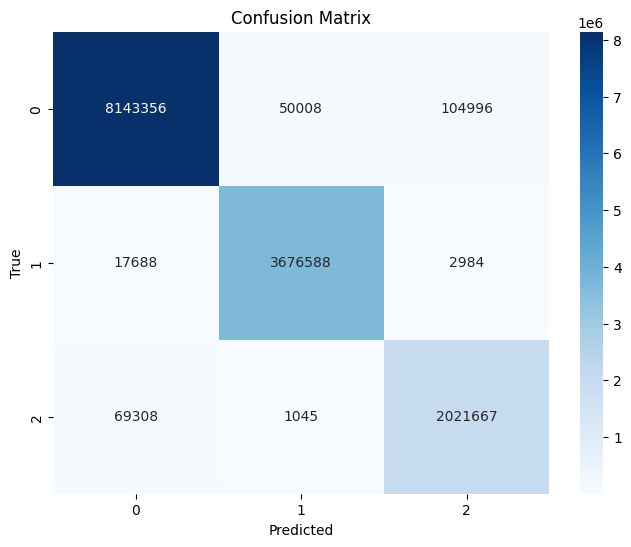

ROC for :



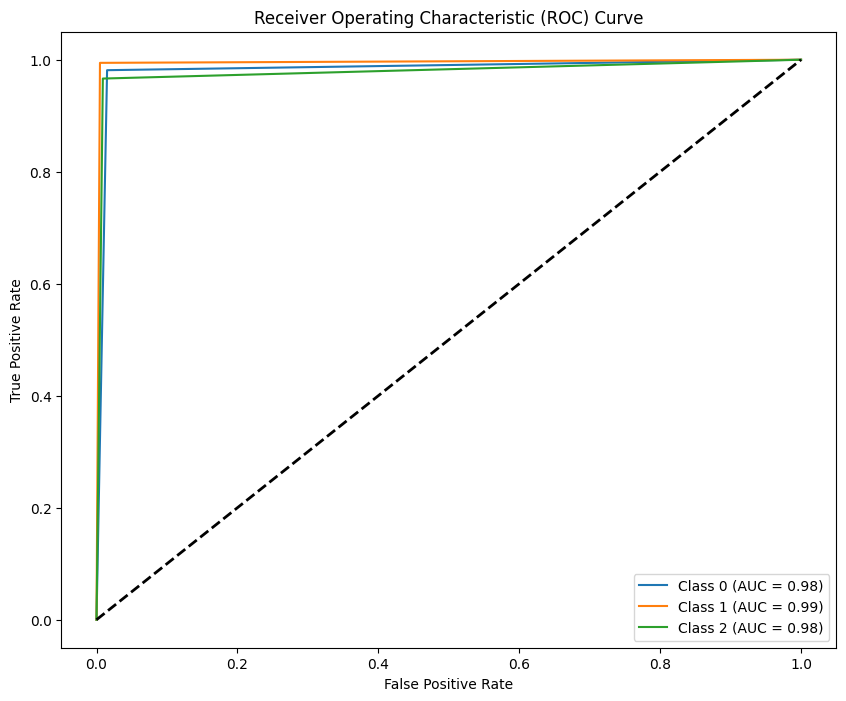

Training and Validation Curves


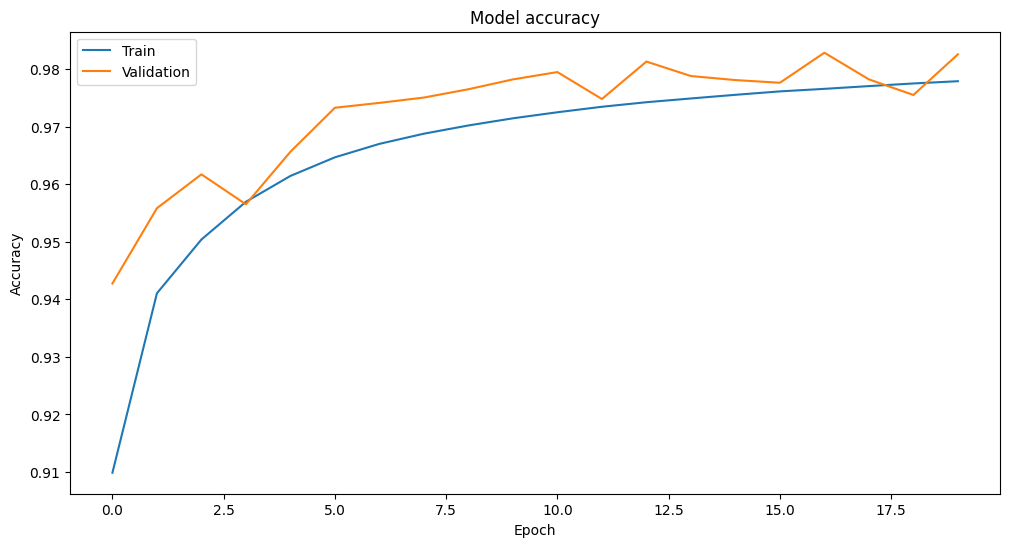

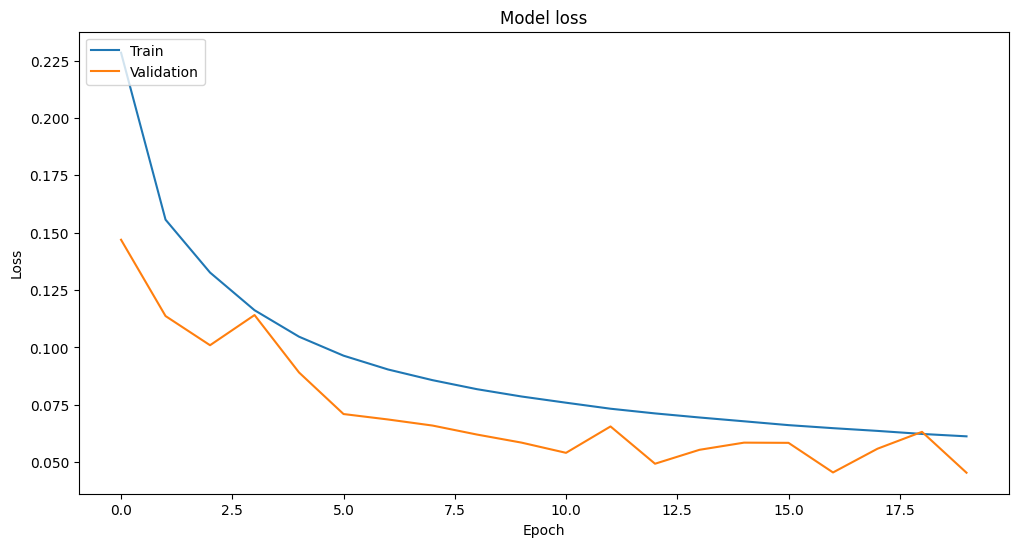

In [12]:

print(f"Confusion Matrix for:\n")
def plot_confusion_matrix(y_true, y_pred, classes):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

# Plot the confusion matrix
y_pred_prob = predict_x
y_pred = np.argmax(y_pred_prob, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=['0', '1', '2'])
# Compute ROC curve and ROC area for each class
print(f"ROC for :\n")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
n_classes = 3
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Training and Validation Curves")
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9825358257309245
